### This is SA-GA network aligner program, and implemented by Elham Mahdipour that is Ph.D. Candidate of Artificial Intelligence at Yazd University, Yazd, Iran.  All copyright reserved by the author.
This program uploads on Github for available on Bioinformatics Journal reviewers.
2020/02/28

You can run the program from first to end and see all the results, but since the population generation process can take a time depended on the node numbers of networks, you can use the populations stored in each program. We saved the populations as the pair of related species that you can see in the input folder and load them on program, such as "mm-ce-pop.pickle". Therefore, you must run follow steps:
1) Run all cells in "Load Graphs", "Swap Graphs", "Define Target Graph",and "Compute Score for create similarity matrix" sections.
2) If you will use saved population, please upload related pickle on root of jupyter notebook, then go "load population" cell and run them; else, please run "multi tasking for initial population", "multi processing for speed up", and "Initialization such as MeAlign" cells. 
3) Run all remains cells to create results. 

# Load Graphs 

In [1]:
import pickle
# write name of species for open such as 'sc-sc-weighted.pickle'
with open('mm-mm-weighted.pickle', 'rb') as f:
    mmlist = pickle.load(f)

In [2]:
# write name of species for open such as 'ce-ce-weighted.pickle'
with open('ce-ce-weighted.pickle', 'rb') as f:
    celist = pickle.load(f)

In [3]:
import networkx as nx
G1=nx.Graph()
for i in range(len(mmlist)):
    if G1.has_node(mmlist[i][0])==False:
        G1.add_node(mmlist[i][0])
    if G1.has_node(mmlist[i][1])==False:
        G1.add_node(mmlist[i][1])
    G1.add_edge(mmlist[i][0],mmlist[i][1],weight=mmlist[i][2])
G1

In [4]:
G2=nx.Graph()
for i in range(len(celist)):
    if G2.has_node(celist[i][0])==False:
        G2.add_node(celist[i][0])
    if G2.has_node(celist[i][1])==False:
        G2.add_node(celist[i][1])
    G2.add_edge(celist[i][0],celist[i][1],weight=celist[i][2])
G2

# Swap graphs if len G1 > len G2

In [5]:
### Check and Swap if G1 > G2 ###
if len(G1)>len(G2):
    temp=G1
    G1=G2
    G2=temp

In [6]:
ed1=G1.edges()

In [7]:
nd1=G1.nodes()

In [8]:
ed2=G2.edges()

In [9]:
nd2=G2.nodes()

In [10]:
el1=list(ed1)
el2=list(ed2)

In [11]:
nd1=list(nd1)
nd2=list(nd2)

In [12]:
degG1 = [val for (node, val) in G1.degree()]


In [13]:
degG2 = [val for (node, val) in G2.degree()]

# Define Target Graph

In [14]:
G_target_na=nx.read_weighted_edgelist('ce-mm.evals')
G_target_na 

In [15]:
gtnode=list(G_target_na.nodes())
g_t_node=[]
for i in range(len(gtnode)):
    if (G1.has_node(gtnode[i])==False and G2.has_node(gtnode[i])==False):
        continue
    else:
        g_t_node.append(gtnode[i])

In [16]:
G_target=nx.Graph()
for i in range(len(g_t_node)):
    for j in range(len(g_t_node)):
        if G_target_na.has_node(g_t_node[i])==False:
            G_target.add_node(g_t_node[i])
        if G_target_na.has_node(g_t_node[j])==False:
            G_target.add_node(g_t_node[j])
        if G_target_na.has_edge(g_t_node[i],g_t_node[j]):
            a=list(G_target_na.get_edge_data(g_t_node[i],g_t_node[j]).values())            
            G_target.add_edge(g_t_node[i],g_t_node[j],weight=a[0])
G_target_na=G_target
G_target_na

# Compute Score for create similarity matrix

In [17]:
def deg_Diff(G1,G2):
    Degree_Difference=np.zeros((len(G1),len(G2)))
    for i in range(len(G1)):
        for j in range(len(G2)):
            Degree_Difference[i][j]=abs(degG1[i]-degG2[j])/max(degG1[i],degG2[j])
    return Degree_Difference

In [18]:
def score_pageRank(X):
    a=nx.pagerank(X)
    return a

In [19]:
def coefficient_pagerank(x,y):  #x is G1, y is G2
   # print(len(x))
    p1=score_pageRank(x)
    b=p1.values()
    pr1=list(b)
    p2=score_pageRank(y)
    c=p2.values()
    pr2=list(c)
    pr=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #print(pr1[i],pr2[j])
            pr[i][j]=abs(pr1[i]-pr2[j])/max(pr1[i],pr2[j])   #minimum pr is maximum similarity of topology 
    return pr

In [20]:
def coefficient_edges(index_node, G, GraphNumber):
    if GraphNumber==1:
        sum_edge=0        
        for i in G.neighbors(nd1[index_node]):                       
            sum_edge=sum_edge+degG1[nd1.index(i)]
        #print(sum_edge)
        temp=(degG1[index_node]-1) if degG1[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG1[index_node]*temp)
    else:
        sum_edge=0        
        for i in G.neighbors(nd2[index_node]):                       
            sum_edge=sum_edge+degG2[nd2.index(i)]
        #print(sum_edge)
        temp=(degG2[index_node]-1) if degG2[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG2[index_node]*temp)
    return coeff_node
    

In [21]:
def compute_Ea(G1,G2):
    Ea_G1=np.zeros(len(G1))
    Ea_G2=np.zeros(len(G2))
    for i in range(len(G1)):
        Ea_G1[i]=coefficient_edges(i, G1, 1)
    for j in range(len(G2)):
        Ea_G2[j]=coefficient_edges(j,G2,2)
    ea=[Ea_G1, Ea_G2]
    return(ea)

In [22]:
# compute relative clustering coefficient difference between node a (in G1) and node b (in G2)
def CD(G1, G2):
    cd=np.zeros((len(G1),len(G2)))
    EA=compute_Ea(G1,G2)
    #print(EA[0])      #Ea for G1
    #print("===================")
    #print(EA[1])      #Ea for G2
    for i in range(len(G1)):
        for j in range(len(G2)):
            cd[i,j]=abs(EA[0][i]-EA[1][j])/max(EA[0][i],EA[1][j])
    return cd

In [23]:
def sequence_score(x,y):
    seq=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            q1=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
            if q1==None:
                c=0
            else:
                c=list(q1.values())
                c=c[0]
            seq[i][j]=c    
            
    return seq

In [24]:
def compute_score(G1,G2):
    coeff_pr=coefficient_pagerank(G1,G2)
    dd=deg_Diff(G1,G2)
    cd=CD(G1,G2)
    seq_sc=sequence_score(G1,G2)
    
    alpha=0.1
    betta=0.2
    gamma=0.2
    zetta=1-alpha-betta-gamma
    s=alpha*(1-coeff_pr)+betta*(1-dd)+gamma*(1-cd)+zetta*seq_sc
    return s

In [25]:
# m is similarity matrix score (SIM)
import numpy as np
m=compute_score(G1,G2)
n=m

# multi tasking for initial population

In [26]:
def task1(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task1')
    for z1 in range(int(len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
  

In [27]:
def task2(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task2')
    for z1 in range(int(len_G1/3),int(2*len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
    

In [28]:
def task3(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task3')
    for z1 in range(int(2*len_G1/3),len_G1):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])

# multi processing for speed up

In [29]:
def fun_rand_permute(len_G1, base_permute, rand_permutation):
    for k in range(len_G1):
        rand_permutation[k]=random.sample(base_permute,len_G1)
    #print(rand_permutation)

# Initialization such as MeAlign

In [30]:
import random
import threading

len_pop=300
len_G1=len(G1)
len_G2=len(G2)
similarity_score_matrix=np.zeros((len_G1,len_G1))
sim_score_matrix=np.zeros((len_G1,len_G1))
pop=np.zeros((len_pop,len_G1,2))
index_score=np.zeros(len_G1)
rand_permutation=np.zeros((len_G1,len_G1))
base_permute = [j for  j in range(0, len_G2)]

for i in range(len_pop):  
    print('wait')
    if i>0:
        do_not_permute = set(base_permute)-set(index_score)
        #print(do_not_permute)
        #print(len(base_permute))
        base_permute.extend(do_not_permute)
        #print(len(do_not_permute))
        #print(len(base_permute))
        #print(base_permute)
    t = threading.Thread(target=fun_rand_permute, args=(len_G1,base_permute, rand_permutation,))
    t.start() 
    t.join()
    #print(rand_permutation)
               
    print('in for loop')
    
    t1 = threading.Thread(target=task1, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,)) 
    t2 = threading.Thread(target=task2, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    t3 = threading.Thread(target=task3, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    # starting thread 1 
    t1.start() 
    # starting thread 2 
    t2.start() 
    # starting thread 3 
    t3.start() 
    # wait until thread 1 is completely executed 
    t1.join() 
    # wait until thread 2 is completely executed 
    t2.join() 
    # wait until thread 3 is completely executed 
    t3.join()
    # both threads completely executed 
    print("Done!, i=",i) 
    
pop

wait
in for loop
task1
task2
task3
Done!, i= 0
wait
in for loop
task1
task2
task3
Done!, i= 1
wait
in for loop
task1
task2
task3
Done!, i= 2
wait
in for loop
task1
task2
task3
Done!, i= 3
wait
in for loop
task1
task2
task3
Done!, i= 4
wait
in for loop
task1
task2
task3
Done!, i= 5
wait
in for loop
task1
task2
task3
Done!, i= 6
wait
in for loop
task1
task2
task3
Done!, i= 7
wait
in for loop
task1
task2
task3
Done!, i= 8
wait
in for loop
task1
task2
task3
Done!, i= 9
wait
in for loop
task1task2

task3
Done!, i= 10
wait
in for loop
task1
task2
task3
Done!, i= 11
wait
in for loop
task1
task2
task3
Done!, i= 12
wait
in for loop
task1
task2
task3
Done!, i= 13
wait
in for loop
task1
task2
task3
Done!, i= 14
wait
in for loop
task1
task2
task3
Done!, i= 15
wait
in for loop
task1
task2
task3
Done!, i= 16
wait
in for loop
task1
task2
task3
Done!, i= 17
wait
in for loop
task1
task2
task3
Done!, i= 18
wait
in for loop
task1
task2
task3
Done!, i= 19
wait
in for loop
task1task2

task3
Done!, i= 20
wa

Done!, i= 169
wait
in for loop
task1
task2
task3
Done!, i= 170
wait
in for loop
task1
task2
task3
Done!, i= 171
wait
in for loop
task1
task2
task3
Done!, i= 172
wait
in for loop
task1
task2
task3
Done!, i= 173
wait
in for loop
task1
task2
task3
Done!, i= 174
wait
in for loop
task1
task2
task3
Done!, i= 175
wait
in for loop
task1
task2
task3
Done!, i= 176
wait
in for loop
task1
task2
task3
Done!, i= 177
wait
in for loop
task1
task2
task3
Done!, i= 178
wait
in for loop
task1
task2
task3
Done!, i= 179
wait
in for loop
task1
task2
task3
Done!, i= 180
wait
in for loop
task1
task2
task3
Done!, i= 181
wait
in for loop
task1
task2
task3
Done!, i= 182
wait
in for loop
task1
task2
task3
Done!, i= 183
wait
in for loop
task1task2

task3
Done!, i= 184
wait
in for loop
task1
task2
task3
Done!, i= 185
wait
in for loop
task1
task2
task3
Done!, i= 186
wait
in for loop
task1
task2
task3
Done!, i= 187
wait
in for loop
task1
task2
task3
Done!, i= 188
wait
in for loop
task1
task2task3

Done!, i= 189
wait
i

array([[[0.000e+00, 1.583e+03],
        [1.000e+00, 2.154e+03],
        [2.000e+00, 2.825e+03],
        ...,
        [6.200e+02, 5.050e+02],
        [6.210e+02, 2.543e+03],
        [6.220e+02, 1.530e+02]],

       [[0.000e+00, 9.110e+02],
        [1.000e+00, 1.293e+03],
        [2.000e+00, 2.372e+03],
        ...,
        [6.200e+02, 5.050e+02],
        [6.210e+02, 2.917e+03],
        [6.220e+02, 2.619e+03]],

       [[0.000e+00, 2.456e+03],
        [1.000e+00, 5.020e+02],
        [2.000e+00, 2.677e+03],
        ...,
        [6.200e+02, 9.680e+02],
        [6.210e+02, 1.623e+03],
        [6.220e+02, 1.530e+02]],

       ...,

       [[0.000e+00, 2.678e+03],
        [1.000e+00, 1.466e+03],
        [2.000e+00, 2.886e+03],
        ...,
        [6.200e+02, 4.830e+02],
        [6.210e+02, 1.942e+03],
        [6.220e+02, 2.046e+03]],

       [[0.000e+00, 1.059e+03],
        [1.000e+00, 1.557e+03],
        [2.000e+00, 1.964e+03],
        ...,
        [6.200e+02, 2.650e+03],
        [6.210e+02

# save population

In [31]:
import pickle
with open('mm-ce-base_permute.pickle', 'wb') as f:
    pickle.dump(base_permute, f)

In [32]:
import pickle
with open('mm-ce-pop.pickle', 'wb') as f:
    pickle.dump(pop, f)

## You can load population if there is save population such as 'ce-sc-pop.pickle'

# load population

In [ ]:
import pickle
with open('mm-ce-base_permute.pickle', 'rb') as f:
    base_permute = pickle.load(f)

In [ ]:
with open('mm-ce-pop.pickle', 'rb') as f:
    pop = pickle.load(f)

# compute measure edge correctness, ics, nc and s3

In [33]:
# ec function
def ec_func(pop1,pop2):
    a=list(G1.neighbors(pop1));
    b=list(G2.neighbors(pop2));
    for i in range(len(a)):
        for j in range(len(b)):
           # print(pop1,a[i],G1.has_edge(pop1,a[i]))
           # print(pop2,b[j],G2.has_edge(pop2,b[j]))
           # print(G_target_na.has_edge(a[i],b[j]))
            if(G1.has_edge(pop1,a[i]) and G2.has_edge(pop2,b[j]) and G_target_na.has_edge(a[i],b[j])):
                return True
    return False 

In [34]:
def induced_function_for_initialpop(sub_pop):
    num_induced=0
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    for i in range(len(sub_g2)):
        for j in range(i,len(sub_g2)):
            if G2.has_edge(nd2[int(sub_g2[i])], nd2[int(sub_g2[j])]):
                num_induced=num_induced+1
    return num_induced

In [35]:
len_pop=len(pop)
score_ec=np.zeros(len_pop)
score_ics=np.zeros(len_pop)
score_s3=np.zeros(len_pop)
score_nc=np.zeros(len_pop)
score_ncorectness=np.zeros(len_pop)
num_seq=np.zeros(len_pop)

p=pop 
len_G1=len(G1)
map_items=[] 


for i in range(len(p)):
    ea=0
    nc=0
    sub_pop=p[i]
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    num_induced=induced_function_for_initialpop(sub_pop) 
    #print("number induced for i=",i," is: ",num_induced)
    
    for j in range(len_G1):                          
         if G_target_na.has_edge(nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]):
            num_seq[i]+=1  # create sequence matrix 
            map_items.append([nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]])
            if (ec_func(nd1[int(p[i][j][0])],nd2[int(p[i][j][1])])):
                ea=ea+1                
            
            nc=nc+2
                 
    score_ec[i]=(ea/G1.number_of_edges())*100
    score_ics[i]=(ea/num_induced)*100
    score_s3[i]=(ea/(G1.number_of_edges()+num_induced-ea))*100
    score_nc[i]=(nc/(G1.number_of_nodes()))*100 # node coverage    
    score_ncorectness[i]=(nc/G_target_na.number_of_nodes())*100

print('ec')
print(score_ec)
print('ics')
print(score_ics)
print('s3')
print(score_s3)
print('node coverage: ',score_nc)
print('node correctness',score_ncorectness)

ec
[14.375      13.63636364 12.95454545 12.84090909 13.57954545 13.46590909
 13.35227273 13.52272727 13.125      14.03409091 13.75       13.01136364
 12.84090909 13.40909091 13.69318182 13.01136364 13.125      13.01136364
 13.01136364 14.31818182 13.75       14.03409091 13.80681818 14.20454545
 13.40909091 14.20454545 12.67045455 13.86363636 13.46590909 13.46590909
 12.72727273 13.29545455 13.52272727 13.92045455 13.18181818 13.86363636
 13.35227273 13.86363636 13.75       13.01136364 13.80681818 13.97727273
 12.89772727 13.46590909 13.46590909 14.26136364 13.63636364 14.03409091
 13.57954545 13.18181818 12.55681818 13.92045455 13.69318182 12.95454545
 13.35227273 14.43181818 13.06818182 12.67045455 14.09090909 13.40909091
 13.80681818 14.20454545 13.01136364 13.63636364 13.46590909 13.75
 13.46590909 13.35227273 13.52272727 13.40909091 13.18181818 13.80681818
 12.95454545 14.26136364 13.80681818 13.46590909 13.23863636 13.86363636
 13.06818182 13.29545455 13.35227273 12.95454545 13.35

## number of matched sequences 

In [36]:
num_seq

array([253., 240., 228., 226., 239., 237., 235., 238., 231., 247., 242.,
       229., 226., 236., 241., 229., 231., 229., 229., 252., 242., 247.,
       243., 250., 236., 250., 223., 244., 237., 237., 224., 234., 238.,
       245., 232., 244., 235., 244., 242., 229., 243., 246., 227., 237.,
       237., 251., 240., 247., 239., 232., 221., 245., 241., 228., 235.,
       254., 230., 223., 248., 236., 243., 250., 229., 240., 237., 242.,
       237., 235., 238., 236., 232., 243., 228., 251., 243., 237., 233.,
       244., 230., 234., 235., 228., 235., 246., 243., 231., 233., 241.,
       240., 243., 228., 233., 230., 245., 227., 239., 230., 214., 245.,
       242., 233., 245., 244., 234., 242., 224., 243., 240., 242., 242.,
       222., 224., 231., 233., 237., 238., 234., 224., 235., 234., 237.,
       230., 235., 240., 226., 249., 239., 245., 242., 227., 237., 226.,
       251., 238., 240., 215., 245., 233., 237., 233., 254., 229., 232.,
       238., 240., 236., 238., 226., 237., 236., 23

## compute topology score

In [37]:
#compute Final Score
tscore=np.zeros(len_pop)
for i in range(len(p)):
    tscore[i]=(0.25*(score_ec[i]/G1.number_of_edges())+0.25*(score_s3[i]/(G1.number_of_edges()+score_ics[i]-score_ec[i]))+0.25*(score_ics[i]/2*G1.number_of_edges())+0.25*(score_nc[i]/(G1.number_of_nodes()+G2.number_of_nodes())))
print(tscore)

[5505.44923878 5959.37662018 5257.8698347  5469.75512404 5848.72943135
 5979.36637026 5644.11327827 6270.66731246 5671.88333906 5270.61990881
 6002.26353859 5348.2035711  4879.30151993 5369.19152478 5977.46079616
 5864.96754056 5482.20897    5292.02504366 5679.82788729 5555.11927161
 5522.83028161 6057.9799394  5346.00872227 5467.20579305 5686.75550092
 5777.31992796 5180.57824248 6530.42248385 5754.97544078 5523.31361772
 5379.92073645 5739.13888316 5364.76265103 5969.0010962  5734.83983957
 6256.41909369 5662.65907879 5704.57839715 5627.91569127 5548.46640933
 5324.7099154  5788.24416091 4949.46304192 5972.5171626  5465.41733273
 5483.62370696 5404.30749914 5684.10931015 5226.64873267 5272.73561089
 5325.30916945 5643.98787682 6186.7065105  5422.71091691 5523.51273766
 5875.92923455 5763.10626193 5575.00805455 5407.34289359 5120.32404237
 5729.91229515 5646.82623984 5183.13579891 5886.29629363 5793.34188997
 5961.9348356  5408.72221541 5589.19765916 5703.71228715 6108.24384182
 5914.

# Compute Topology and Sequence score

In [38]:
# Final Score
score=np.zeros(len_pop)
alpha=0.5
for i in range (len(p)):
    score[i]=alpha*tscore[i]+(1-alpha)*num_seq[i]   
score

array([2879.22461939, 3099.68831009, 2742.93491735, 2847.87756202,
       3043.86471567, 3108.18318513, 2939.55663913, 3254.33365623,
       2951.44166953, 2758.8099544 , 3122.1317693 , 2788.60178555,
       2552.65075997, 2802.59576239, 3109.23039808, 3046.98377028,
       2856.604485  , 2760.51252183, 2954.41394365, 2903.5596358 ,
       2882.41514081, 3152.4899697 , 2794.50436113, 2858.60289652,
       2961.37775046, 3013.65996398, 2701.78912124, 3387.21124192,
       2995.98772039, 2880.15680886, 2801.96036822, 2986.56944158,
       2801.38132552, 3107.0005481 , 2983.41991978, 3250.20954684,
       2948.82953939, 2974.28919857, 2934.95784564, 2888.73320467,
       2783.8549577 , 3017.12208046, 2588.23152096, 3104.7585813 ,
       2851.20866637, 2867.31185348, 2822.15374957, 2965.55465507,
       2732.82436633, 2752.36780545, 2773.15458473, 2944.49393841,
       3213.85325525, 2825.35545845, 2879.25636883, 3064.96461728,
       2996.55313097, 2899.00402727, 2827.67144679, 2678.16202

## Define function for fitness and compute final score

In [39]:
def induced_function_for_pop(wpop):
    counter_induced=0
    subg=list(set([wpop[i][1] for i in range(len_G1)]))
    for i in range(len(subg)):
        for j in range(i,len(subg)):
            if G2.has_edge(nd2[int(subg[i])], nd2[int(subg[j])]):
                counter_induced=counter_induced+1
    #print("con: ",counter_induced)
    return counter_induced

In [40]:
def Fitness(wpop,counter_induced):
    ec_temp=0
    nc_temp=0
    num_seq_temp=0
    score_ncorectness=0
    
  
    for j in range(len_G1):        
        x1=int(wpop[j][0])
        x2=int(wpop[j][1])
        if G_target_na.has_edge(nd1[x1],nd2[x2]):
            num_seq_temp+=1 
            if (ec_func(nd1[x1],nd2[x2])):
                ec_temp=ec_temp+1                
            nc_temp=nc_temp+2
                 
    score_ec_temp=(ec_temp/G1.number_of_edges())*100
    score_ics_temp=(ec_temp/counter_induced)*100
    score_s3_temp=(ec_temp/(G1.number_of_edges()+counter_induced-ec_temp))*100
    score_nc_temp=(nc_temp/G1.number_of_nodes())*100 # node coverage 
    score_ncorectness=(nc/G_target_na.number_of_nodes())*100
    
    
     # local measures
    pre=ec_temp/G_target_na.number_of_edges()*100
    rec=ec_temp/len(wpop)*100
    fsc=2*((pre*rec)/(pre+rec))
    
    if (GbestFlag==True):
        print('ec')
        print(score_ec_temp)
        print('ics')
        print(score_ics_temp)
        print('s3')
        print(score_s3_temp)
        print('node coverage: ',score_nc_temp)
        print('node correctness: ',score_ncorectness)
        print('num_seq',num_seq_temp)
        print('precision: ',pre)
        print('Recall: ',rec)
        print('F-score: ',fsc)

    alpha=0.5
    tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
    score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
    print('score:',score_temp)
    return score_temp,pre,rec,fsc


# SA-GA method

In [41]:
def crossover(index,r1): 
    tp=[]
    
    for i in range(len_pop-1):            
            if (r1>0):
                alpha=random.random()
                P_crossover=(pop[i][dim]*r1-r1*2*alpha)/1000
                print(P_crossover)
                tp.append(pop[i][0:len_G1])                
                for j in range(int(P_crossover)):
                    x=random.randint(0,len_G1-1)
                    #print('x',x)
                    y=np.argmax(m[x])
                    #print('y',y,'index',index,len(tp))
                    #print(tp[index])
                    #print(nd1[int(tp[index][x][0])],nd2[y])
                    #print('crossover ===============',G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y]))
                    if (G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y])):                                                    
                        tp[index][x][1]=y
                        fit,pre,rec,fsc=Fitness(tp[index],counter_induced)
                        tp[index].append(fit)
                        if(fit>pop[i][dim]):
                            pool.append(tp)
                            print('move crossover')
                index=index+1

In [42]:
def mutation(index):   
    tp=[]
    for i in range(len_pop-1):
        pm=random.random()
        if (pm>0.1):               
            tp.append(pop[i][0:len_G1])
            x=random.randint(0,len_G1-1)
            #print('x',x)
            y=np.argmax(m[x])
            #print('y',y,'index',index,len(tp),tp[index])
            #print(nd1[int(tp[index][x][0])],nd2[y])
            #print('mutation=====',G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y]))
            if (G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y])):                                                    
                tp[index][x][1]=y                            
                fit,pre,rec,fsc=Fitness(tp[index],counter_induced)
                tp[index].append(fit)
                if(fit>pop[i][dim]):
                    pool.append(tp)
                    print('move mutation')
            index=index+1

# Hybrid SA-GA proposed method

In [43]:
# Implementation of Hybrid SA-GA Algorithm
import random
from operator import itemgetter
import concurrent.futures

len_G1=len(G1)
pool=[]
dim=len_G1
pop=p.tolist()

[pop[i].append(score[i]) for i in range(len_pop)]
#[print(pop[i][dim]) for i in range(len_pop)]

pop=sorted(pop, key=itemgetter(dim),reverse=True)


GBest=pop[0]
#print("GBest: ",GBest)


iteration=0
max_epoch=2

GbestFlag=False
max_score=max(score)
r1=10 # Initial temperature

while (iteration<max_epoch and r1>0): 
    # counter induced for ics compute            
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(induced_function_for_pop,GBest)
        counter_induced = future.result()
        #print("counter induced: ",counter_induced)
    
    index=0
    print('it',iteration)
    crossover(index,r1)
    mutation(index)
                
    # selection
    if(len(pool)>0):
        pool=pool[0][0:len(pool[0])]
        pool=sorted(pool, key=itemgetter(dim), reverse=True)
        pop[-len(pool):]=pool[0:]
        pop=sorted(pop, key=itemgetter(dim),reverse=True)
        pool=[]
    if (pop[0][dim]>GBest[dim]):
        GBest=pop[0]
    r1=r1-0.1
    iteration=iteration+1
    
#print("GBest: ",GBest)    
print("score:", score)
#******** map items **********
map_items=[]
weight=[]
for i in range(len_pop):
    for j in range(len_G1):
        if G_target_na.has_edge(nd1[int(pop[i][j][0])],nd2[int(pop[i][j][1])]):
            map_items.append([nd1[int(pop[i][j][0])],nd2[int(pop[i][j][1])]]) 
            weight.append(G_target_na.get_edge_data(nd1[int(pop[i][j][0])],nd2[int(pop[i][j][1])])) 

print("end")

it 0
34.679399000922736
score: 3468.1195692871165
score: 3468.1195692871165
score: 3468.1195692871165
score: 3468.1195692871165
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3495.753988764398
move crossover
score: 3509.5711985069765
move crossover
score: 3523.3884082521854
move crossover
score: 3523.3884082521854
move crossover
score: 3523.3884082521854
move crossover
score: 3523.3884082521854
move crossover
score: 3523.3884082521854
move crossover
score: 3523.3884082521854
move crossover
score: 3537.2056180000263
move crossover
score: 3551.0228277505053
move crossover
score: 3564.8400375036235
move crossover
score: 3564.8400375036235
move crossover
34.56029163736847
score: 3371.399101198972
score: 3371.399101198972
score: 3371.399101198972
score: 3385.216310918035
score: 3399.033520639697
score: 3412.850730363962
score: 3412.8

score: 3551.0228277505053
move crossover
score: 3564.8400375036235
move crossover
score: 3564.8400375036235
move crossover
score: 3578.657247259385
move crossover
score: 3578.657247259385
move crossover
score: 3578.657247259385
move crossover
32.530060580490066
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
scor

score: 3302.3130526425325
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
31.696830097185455
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 330

score: 3440.485149820313
move crossover
score: 3454.3023595524073
move crossover
score: 3468.1195692871165
move crossover
31.0725287573801
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3385.216310918035
move crossover
score: 3385.216310918035
move crossover
score: 3385.216310918035
move crossover
31.054347068720

score: 3551.0228277505053
move crossover
30.717020024915012
score: 3205.592584771757
move crossover
score: 3219.4097944598875
move crossover
score: 3219.4097944598875
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3274.678633238035
move crossover
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
30.679020903462558
score: 3343.764681768632
move crossover
score: 3343.764681768632
mo

score: 3260.861423539647
move crossover
score: 3274.678633238035
move crossover
score: 3274.678633238035
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
30.354093121417584
score: 3219.4097944598875
move crossover
score: 3219.4097944598875
move crossover
score: 3219.4097944598875
move crossover
score: 3219.

score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3426.6679400908333
move crossover
30.1689643017853
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3426.6679400908333
move crossover
score: 3440.485149820313
move crossover
score: 3440.485149820313
move crossover
score: 3454.3023595524073
move crossover
score: 3454.3023595524073
move crossover
score: 3454.3023595524073
move crossover
score: 3454.3023595524073
move crossover
score: 3454.3023595524073
move crossover
score: 3468.1195692871165
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
30.132298923891955
score: 3274.678633238035
move crossover
score: 3288.495842938996
move crosso

score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3274.678633238035
move crossover
score: 3274.678633238035
move crossover
score: 3274.678633238035
move crossover
score: 3274.678633238035
move crossover
score: 3274.678633238035
move crossover
score: 3274.678633238035
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
30.036405056486633
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3371

score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3385.216310918035
move crossover
score: 3385.216310918035
move crossover
29.864167212959657
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3412.850730363962
move crossover
score: 3412.8507

score: 3454.3023595524073
move crossover
score: 3454.3023595524073
move crossover
score: 3468.1195692871165
move crossover
score: 3468.1195692871165
move crossover
score: 3468.1195692871165
move crossover
score: 3468.1195692871165
move crossover
score: 3481.936779024446
move crossover
score: 3495.753988764398
move crossover
score: 3509.5711985069765
move crossover
score: 3509.5711985069765
move crossover
score: 3509.5711985069765
move crossover
score: 3509.5711985069765
move crossover
score: 3509.5711985069765
move crossover
score: 3523.3884082521854
move crossover
29.642656501364815
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3426.6679400908333
move crossover
score: 3440.485149820313
move crossover
score: 3454.3023595524073
move crossover
score: 

score: 3426.6679400908333
move crossover
score: 3440.485149820313
move crossover
29.533951864193387
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3191.775375086184
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3219.4097944598875
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
29.5312328982674
score: 3108.8721170262406
move crossover
score: 3108.8721170262406
move crossover
score: 3108.8721170262406
move crossover
score: 3108.8721170262406
move crossover
score: 3122.6893266965453
move crossover
score: 3122.6893266965453
move cr

score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
29.395022292412595
score: 3302.3130526425325
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
sco

score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3399.033520639697
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3426.6679400908333
move crossover
29.11654240195938
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.94

score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3385.216310918035
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3412.850730363962
move crossover
score: 3426.6679400908333
move crossover
score: 3426.6679400908333
move crossover
score: 3426.6679400908333
move crossover
score: 3440.485149820313
move crossover
score: 3454.3023595524073
move crossover
score: 3468.1195692871165
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
28.92368928445427
score: 3329.9474720573467
move crossover
score: 3329.9474720573467
move crossover
score: 3329.94

score: 3509.5711985069765
move crossover
score: 3509.5711985069765
move crossover
score: 3523.3884082521854
move crossover
score: 3537.2056180000263
move crossover
score: 3551.0228277505053
move crossover
score: 3564.8400375036235
move crossover
score: 3578.657247259385
move crossover
28.672452336445552
score: 3481.936779024446
move crossover
score: 3481.936779024446
move crossover
score: 3495.753988764398
move crossover
score: 3509.5711985069765
move crossover
score: 3509.5711985069765
move crossover
score: 3509.5711985069765
move crossover
score: 3509.5711985069765
move crossover
score: 3509.5711985069765
move crossover
score: 3523.3884082521854
move crossover
score: 3523.3884082521854
move crossover
score: 3523.3884082521854
move crossover
score: 3523.3884082521854
move crossover
score: 3537.2056180000263
move crossover
score: 3551.0228277505053
move crossover
score: 3551.0228277505053
move crossover
score: 3564.8400375036235
move crossover
score: 3578.657247259385
move crossover
sc

score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
28.39615904952968
score: 3025.9688590575006
move crossover
score: 3039.786068712653
move crossover
score: 3039.786068712653
move crossover
score: 3053.6032783703236
move crossover
score: 3067.4204880305133
move crossover
score: 3067.4204880305133
move crossover
score: 3067.4204880305133
move crossover
score: 3081.237697693228
move crossover
score: 3081.237697693228
move crossover
score: 3081.237697693228
move crossover
score: 3095.0549073584684
move crossover
score: 3095.0549073584684
move crossover
score: 3095.0549073584684
move crossover
score: 3095.0549073584684
move crossover
score: 3108.8721170262406
move crossover
score: 3122.6893266965453
move crossover
score: 3122.6893266965453
move crossover
28.395145851360205
score: 3274.678633238035
move crossover
score: 3288.495842938996
move crossover
score: 3302.3130526425325
mo

score: 3122.6893266965453
move crossover
score: 3136.5065363693857
move crossover
score: 3136.5065363693857
move crossover
score: 3150.323746044767
move crossover
score: 3164.140955722692
move crossover
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3191.775375086184
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
28.2306265896243
score: 3191.775375086184
move crossover
score: 3205.592584771757
move crossover
score: 3219.4097944598875
move crossover
score: 3219.4097944598875
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.2

score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3274.678633238035
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
score: 3343.764681768632
move crossover
28.03990738227883
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3399.033520639697
move crossover
score: 3412.850730363962
move crossover
score: 3426.6679400908333
move crossover
score: 3426.6679400908333
move crossover
score: 3426.6

score: 3260.861423539647
move crossover
score: 3274.678633238035
move crossover
score: 3274.678633238035
move crossover
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
27.94220105676458
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3426.6

score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3316.1302623486476
move crossover
score: 3329.9474720573467
move crossover
score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3385.216310918035
move crossover
score: 3385.216310918035
move crossover
score: 3385.216310918035
move crossover
score: 3399.033520639697
move crossover
score: 3399.033520639697
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
27.770530773354047
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3399.033520639697
move crossover
score: 3412.850730363962
move crossover
score: 3426.6679400908333
move crossover
score: 3426.6679400908333
move crossover
score: 3440.485149820313
move crossover
score: 3454.3

score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
27.474868574192918
score: 3219.4097944598875
move crossover
score: 3233.227004150577
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 

score: 3164.140955722692
move crossover
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3191.775375086184
move crossover
score: 3191.775375086184
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3219.4097944598875
move crossover
score: 3219.4097944598875
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
27.071729027918227
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3177.9581654031635
move crossover
score: 3191.

score: 3343.764681768632
move crossover
score: 3357.5818914825054
move crossover
score: 3357.5818914825054
move crossover
score: 3371.399101198972
move crossover
score: 3385.216310918035
move crossover
score: 3399.033520639697
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
score: 3412.850730363962
move crossover
26.70529783514787
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3233.227004150577
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3247.0442138438293
move crossover
score: 3260.861423539647
move crossover
score: 3260.861423539647
move crossover
score: 3274

score: 3205.592584771757
move crossover
score: 3205.592584771757
move crossover
score: 3219.4097944598875
move crossover
score: 3233.227004150577
move crossover
score: 3247.0442138438293
move crossover
score: 3260.861423539647
move crossover
score: 3274.678633238035
move crossover
score: 3288.495842938996
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3302.3130526425325
move crossover
score: 3316.1302623486476
move crossover
25.877584000915423
score: 3012.1516494048624
move crossover
score: 3012.1516494048624
move crossover
score: 3012.1516494048624
move crossover
score: 3012.1516494048624
move crossover
score: 3012.1516494048624
move crossover
score: 3012.1516494048624
move crossover
score: 3012.1516494048624
move crossover
score: 3025.9688590575006
move crossover
score: 3025.9688590575006
move crossover
score: 3025.9688590575006
move crossover
score: 3025.9688590575006
move crossover
score: 3039.786068712653
move crossover
scor

score: 3689.194925401058
move mutation
score: 3468.1195692871165
move mutation
score: 3509.5711985069765
move mutation
score: 3260.861423539647
move mutation
score: 3426.6679400908333
move mutation
score: 3316.1302623486476
move mutation
score: 3385.216310918035
move mutation
score: 3329.9474720573467
move mutation
score: 3412.850730363962
move mutation
score: 3537.2056180000263
move mutation
score: 3481.936779024446
move mutation
score: 3426.6679400908333
move mutation
score: 3385.216310918035
move mutation
score: 3440.485149820313
move mutation
score: 3495.753988764398
move mutation
score: 3343.764681768632
move mutation
score: 3371.399101198972
move mutation
score: 3495.753988764398
move mutation
score: 3371.399101198972
move mutation
score: 3302.3130526425325
move mutation
score: 3454.3023595524073
move mutation
score: 3523.3884082521854
move mutation
score: 3357.5818914825054
move mutation
score: 3578.657247259385
move mutation
score: 3440.485149820313
move mutation
score: 3164.14

score: 3282.628052347058
score: 3294.968759609173
score: 3294.968759609173
score: 3307.3094668737717
score: 3307.3094668737717
score: 3307.3094668737717
score: 3319.6501741408574
score: 3331.9908814104338
score: 3344.3315886825026
score: 3356.6722959570684
34.470428183356425
score: 3257.9466378302686
score: 3257.9466378302686
score: 3257.9466378302686
score: 3257.9466378302686
score: 3257.9466378302686
score: 3257.9466378302686
score: 3257.9466378302686
score: 3270.287345087424
score: 3270.287345087424
score: 3282.628052347058
score: 3282.628052347058
score: 3282.628052347058
score: 3294.968759609173
score: 3307.3094668737717
score: 3307.3094668737717
score: 3319.6501741408574
score: 3319.6501741408574
score: 3319.6501741408574
score: 3331.9908814104338
score: 3331.9908814104338
score: 3331.9908814104338
score: 3344.3315886825026
34.45852132979565
score: 3233.2652233233775
score: 3233.2652233233775
score: 3233.2652233233775
score: 3233.2652233233775
score: 3233.2652233233775
score: 324

score: 3270.287345087424
score: 3270.287345087424
34.05516456621499
score: 3159.2209798618514
score: 3159.2209798618514
score: 3171.561687099296
score: 3171.561687099296
score: 3183.9023943391935
score: 3183.9023943391935
score: 3183.9023943391935
score: 3183.9023943391935
score: 3196.2431015815473
score: 3196.2431015815473
score: 3196.2431015815473
score: 3208.583808826361
score: 3208.583808826361
score: 3208.583808826361
score: 3208.583808826361
score: 3220.9245160736364
score: 3220.9245160736364
score: 3233.2652233233775
score: 3233.2652233233775
score: 3245.6059305755875
score: 3245.6059305755875
score: 3245.6059305755875
score: 3245.6059305755875
34.04234537841249
score: 3159.2209798618514
score: 3159.2209798618514
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3183.90239433

score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3122.198858164209
score: 3134.539565394312
score: 3134.539565394312
score: 3134.539565394312
score: 3146.8802726268586
score: 3159.2209798618514
score: 3159.2209798618514
score: 3171.561687099296
score: 3183.9023943391935
score: 3183.9023943391935
33.64513712621273
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3109.8581509365476
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3134.539565394312
score: 3146.8802726268586
score: 3159.2209798618514
score: 3171.561687099296
score: 3171.561687099296
score: 3183.9023943391935
score: 3196.2431015815473
score: 3196.2431015815473
score: 3196.2431015815473
score: 3196.2431015815473
score: 3208.583808826361
score: 3220.9245160736364
score: 3233.2652233233775
score: 3245.6059305755875
score: 3245.6059305755875
score: 3245.6059305755875
score: 

score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3171.561687099296
score: 3183.9023943391935
score: 3196.2431015815473
33.37306644672176
score: 3097.517443711325
score: 3109.8581509365476
score: 3122.198858164209
score: 3134.539565394312
score: 3146.8802726268586
score: 3146.8802726268586
score: 3146.8802726268586
score: 3146.8802726268586
score: 3159.2209798618514
score: 3171.561687099296
score: 3183.9023943391935
score: 3196.2431015815473
score: 3196.2431015815473
score: 3196.2431015815473
score: 3208.583808826361
score: 3208.583808826361
score: 3208.583808826361
score: 3220.9245160736364
score: 3233.2652233233775
score: 3233.2652233233775
score: 3233.2652233233775
33.36535345048089
score: 3109.8581509365476
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3134.539565394312
score: 3134.539565394312
score: 3146.8802726268586
score: 3146.8802726268586
score: 3146.88027262

score: 3060.4953220502534
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3097.517443711325
score: 3097.517443711325
score: 3097.517443711325
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3122.198858164209
score: 3134.539565394312
score: 3134.539565394312
score: 3134.539565394312
score: 3134.539565394312
score: 3146.8802726268586
score: 3159.2209798618514
33.22565974106106
score: 3060.4953220502534
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3085.1767364885363
score: 3097.517443711325
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3134.53956539

score: 3097.517443711325
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8581509365476
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
32.956738621414765
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3097.517443711325
score: 3097.517443711325
score: 3097.517443711325
score: 3109.8581509365476
score: 3122.198858164209
score: 3134.539565394312
score: 3134.539565394312
score: 3146.8802726268586
score: 3146.8802726268586
score: 3146.8802726268586
score: 3146.8802726268586
score: 3159.2209798618514
score: 3171.561687099296
score: 3183.9023943391935
score: 3196.2431015815473
score: 3196.2431015815473
32.95163161338168
score: 3134.539565394312
score: 3146.8802726268586
score: 3159.22097986185

score: 3196.2431015815473
score: 3208.583808826361
score: 3208.583808826361
32.82661942988004
score: 3060.4953220502534
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3097.517443711325
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3122.198858164209
score: 3134.539565394312
score: 3134.539565394312
score: 3146.8802726268586
score: 3146.8802726268586
score: 3159.2209798618514
score: 3171.561687099296
score: 3171.561687099296
score: 3183.9023943391935
score: 3183.9023943391935
score: 3196.2431015815473
score: 3208.583808826361
32.81068529607162
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
sco

score: 3035.8139076216758
score: 3035.8139076216758
score: 3048.154614834753
score: 3048.154614834753
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3072.83602926818
score: 3085.1767364885363
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8581509365476
score: 3122.198858164209
score: 3122.198858164209
32.678849764941305
score: 2998.791785996952
score: 2998.791785996952
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3023.4732004110183
score: 3035.8139076216758
score: 3035.8139076216758
score: 3035.8139076216758
score: 3035.8139076216758
score: 3035.8139076216758
score: 3048.154614834753
score: 3060

score: 3023.4732004110183
score: 3023.4732004110183
score: 3023.4732004110183
score: 3023.4732004110183
score: 3023.4732004110183
score: 3035.8139076216758
score: 3035.8139076216758
score: 3035.8139076216758
score: 3048.154614834753
score: 3048.154614834753
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3072.83602926818
score: 3072.83602926818
32.543391885867635
score: 3023.4732004110183
score: 3023.4732004110183
score: 3023.4732004110183
score: 3035.8139076216758
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3060.4953220502534
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8

score: 3035.8139076216758
score: 3035.8139076216758
score: 3048.154614834753
score: 3060.4953220502534
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8581509365476
score: 3122.198858164209
score: 3134.539565394312
score: 3134.539565394312
score: 3146.8802726268586
score: 3146.8802726268586
score: 3146.8802726268586
32.402523218041225
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3023.4732004110183
score: 3023.4732004110183
score: 3023.4732004110183
score: 3035.8139076216758
score: 3035.8139076216758
score: 3035.8139076216758
score: 3035.8139076216758
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
score: 3072.83602926818
score: 3

score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8581509365476
score: 3122.198858164209
32.274810884347275
score: 3035.8139076216758
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3060.4953220502534
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3097.517443711325
score: 3097.517443711325
score: 3097.517443711325
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
32.

score: 3011.132493202778
score: 3023.4732004110183
score: 3023.4732004110183
score: 3023.4732004110183
score: 3023.4732004110183
score: 3035.8139076216758
score: 3035.8139076216758
score: 3035.8139076216758
score: 3048.154614834753
score: 3048.154614834753
score: 3060.4953220502534
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3097.517443711325
score: 3109.8581509365476
32.14475074528808
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3023.4732004110183
score: 3023.4732004110183
score: 3023.4732004110183
score: 3035.8139076216758
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3060.4953220502534
score: 3060.4953220502534
score: 3072.83602926818
score: 3072.83602926818
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.51744371

score: 2937.088250003931
score: 2937.088250003931
score: 2949.4289571977306
score: 2949.4289571977306
score: 2949.4289571977306
score: 2961.769664393929
score: 2974.110371592531
score: 2986.4510787935374
score: 2998.791785996952
score: 2998.791785996952
score: 3011.132493202778
score: 3023.4732004110183
score: 3023.4732004110183
score: 3035.8139076216758
score: 3048.154614834753
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
32.000517740159516
score: 2974.110371592531
score: 2974.110371592531
score: 2974.110371592531
score: 2974.110371592531
score: 2974.110371592531
score: 2986.4510787935374
score: 2986.4510787935374
score: 2998.791785996952
score: 2998.791785996952
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3023.4732004110183
score: 3035.8139076216758
score: 3048.154614834753
score: 3060.4953220502534
score: 3072.83602926818
score: 3072.83602

score: 3048.154614834753
31.86978429417996
score: 2998.791785996952
score: 3011.132493202778
score: 3023.4732004110183
score: 3035.8139076216758
score: 3035.8139076216758
score: 3048.154614834753
score: 3060.4953220502534
score: 3060.4953220502534
score: 3072.83602926818
score: 3085.1767364885363
score: 3085.1767364885363
score: 3085.1767364885363
score: 3097.517443711325
score: 3109.8581509365476
score: 3109.8581509365476
score: 3109.8581509365476
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
score: 3122.198858164209
31.856104027770677
score: 2949.4289571977306
score: 2949.4289571977306
score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2974.110371592531
score: 2974.110371592531
score: 2986.4510787935374
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 3011.132493202778
score: 3023.4732004110183

score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2974.110371592531
score: 2986.4510787935374
score: 2998.791785996952
score: 2998.791785996952
score: 3011.132493202778
score: 3011.132493202778
score: 3023.4732004110183
score: 3035.8139076216758
score: 3035.8139076216758
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3060.4953220502534
score: 3072.83602926818
score: 3072.83602926818
31.58810438476675
score: 2974.110371592531
score: 2986.4510787935374
score: 2986.4510787935374
score: 2998.791785996952
score: 3011.132493202778
score: 3011.132493202778
score: 3023.4732004110183
score: 3035.8139076216758
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3048.154614834753
score: 3060.4953220502534
score: 3060.4953220502534
score: 3060.4953220502534
31.581917070900076
score: 2961.769664393929
score: 2961.769664393929
sco

score: 2961.769664393929
score: 2974.110371592531
score: 2974.110371592531
score: 2986.4510787935374
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3023.4732004110183
31.4592504063567
score: 2937.088250003931
score: 2949.4289571977306
score: 2949.4289571977306
score: 2949.4289571977306
score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2974.110371592531
score: 2974.110371592531
score: 2974.110371592531
score: 2974.110371592531
score: 2986.4510787935374
score: 2986.4510787935374
score: 2986.4510787935374
score: 2986.4510787935374
score: 2986.4510787935374
score: 2986.4510787935374
score: 2986.4510787935374
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 3011.132493202778
score: 3011.132493202

score: 2937.088250003931
score: 2949.4289571977306
score: 2949.4289571977306
score: 2949.4289571977306
score: 2961.769664393929
score: 2974.110371592531
score: 2974.110371592531
score: 2986.4510787935374
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 2998.791785996952
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
score: 3011.132493202778
31.05084555158948
score: 2937.088250003931
score: 2949.4289571977306
score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2961.769664393929
score: 2974.110371592531
score: 2986.4510787935374
score: 2986.4510787935374
score: 2986.4510787935374
31.039289379348492
score: 2900.0661284369
score: 2900.0661284369
score: 2912.4068356235184
score: 2912.4068356235184
score: 2912.4068356235184
score:

score: 2826.021885367222
score: 2826.021885367222
score: 2838.362592539559
score: 2850.7032997142696
score: 2863.044006891356
score: 2875.3847140708212
score: 2875.3847140708212
score: 2875.3847140708212
score: 2875.3847140708212
score: 2875.3847140708212
score: 2875.3847140708212
score: 2887.7254212526677
score: 2900.0661284369
score: 2912.4068356235184
score: 2924.7475428125276
score: 2924.7475428125276
score: 2924.7475428125276
score: 2937.088250003931
30.623448539777645
score: 2826.021885367222
score: 2838.362592539559
score: 2838.362592539559
score: 2850.7032997142696
score: 2863.044006891356
score: 2863.044006891356
score: 2875.3847140708212
score: 2875.3847140708212
score: 2875.3847140708212
score: 2875.3847140708212
score: 2875.3847140708212
score: 2875.3847140708212
score: 2887.7254212526677
score: 2887.7254212526677
score: 2887.7254212526677
score: 2887.7254212526677
score: 2887.7254212526677
score: 2900.0661284369
score: 2912.4068356235184
30.63580069018731
score: 2826.02188

score: 2826.021885367222
score: 2826.021885367222
score: 2838.362592539559
score: 2850.7032997142696
score: 2850.7032997142696
score: 2850.7032997142696
score: 2850.7032997142696
29.39882970713727
score: 2751.9776423828675
score: 2764.3183495410276
score: 2776.659056701544
score: 2788.999763864418
score: 2788.999763864418
score: 2788.999763864418
score: 2801.340471029654
score: 2813.681178197254
score: 2826.021885367222
score: 2838.362592539559
score: 2838.362592539559
score: 2838.362592539559
score: 2850.7032997142696
score: 2863.044006891356
score: 2863.044006891356
score: 2875.3847140708212
score: 2875.3847140708212
score: 2875.3847140708212
score: 2887.7254212526677
score: 2887.7254212526677
score: 2900.0661284369
score: 2912.4068356235184
score: 2924.7475428125276
score: 2924.7475428125276
29.39967267076134
score: 2801.340471029654
score: 2801.340471029654
score: 2801.340471029654
score: 2813.681178197254
score: 2826.021885367222
score: 2826.021885367222
score: 2826.021885367222
s

end


In [44]:
# GbestFrog
gb=pop[0]
#del gb[dim]
GbestFlag=True
fit_gb,pre,rec,fsc=Fitness(gb,counter_induced)
print('gbest fitness ', fit_gb)

ec
15.568181818181817
ics
29.494079655543597
s3
11.34575569358178
node coverage:  87.96147672552166
node correctness:  39.96584116140051
num_seq 274
precision:  6.773794808405439
Recall:  42.414860681114554
F-score:  11.681944148369219
score: 3381.3537105137007
gbest fitness  3381.3537105137007


# create weighted graph of network alignment

In [45]:
x=[[map_items[i][0],map_items[i][1],int(list(weight[i].values())[0])] for i in range(len(map_items))]
x

[['mm835', 'ce3575', 76],
 ['mm5091', 'ce3575', 55],
 ['mm960', 'ce3575', 82],
 ['mm9171', 'ce5323', 55],
 ['mm4668', 'ce1686', 1189],
 ['mm14022', 'ce17884', 148],
 ['mm3290', 'ce8405', 57],
 ['mm9696', 'ce14248', 46],
 ['mm5042', 'ce5179', 102],
 ['mm3362', 'ce5875', 48],
 ['mm9669', 'ce3694', 138],
 ['mm3314', 'ce3403', 417],
 ['mm8390', 'ce5875', 55],
 ['mm5138', 'ce10379', 95],
 ['mm3178', 'ce7388', 91],
 ['mm9309', 'ce6127', 60],
 ['mm1793', 'ce7388', 66],
 ['mm2048', 'ce788', 62],
 ['mm407', 'ce541', 92],
 ['mm8699', 'ce684', 164],
 ['mm14063', 'ce3160', 160],
 ['mm11243', 'ce6354', 563],
 ['mm2123', 'ce630', 182],
 ['mm2153', 'ce630', 192],
 ['mm6374', 'ce409', 54],
 ['mm3821', 'ce9381', 100],
 ['mm7887', 'ce6376', 181],
 ['mm8967', 'ce11741', 112],
 ['mm2895', 'ce3894', 172],
 ['mm1347', 'ce1906', 161],
 ['mm4294', 'ce4264', 179],
 ['mm11480', 'ce4233', 504],
 ['mm5183', 'ce8997', 115],
 ['mm5034', 'ce630', 94],
 ['mm6549', 'ce9424', 330],
 ['mm592', 'ce11889', 112],
 ['mm5688

## Remove duplication and local alignment
## Compute Global Alignment

In [46]:
unique_xmap=list(set(tuple(y) for y in x))

In [47]:
# unique_xmap has all alignment nodes
unique_xmap

[('mm5688', 'ce4233', 212),
 ('mm45', 'ce3649', 156),
 ('mm7258', 'ce10516', 47),
 ('mm3821', 'ce1979', 93),
 ('mm1472', 'ce13915', 51),
 ('mm1082', 'ce7446', 71),
 ('mm1082', 'ce404', 316),
 ('mm28', 'ce166', 86),
 ('mm6126', 'ce2061', 108),
 ('mm1953', 'ce622', 177),
 ('mm8252', 'ce3981', 161),
 ('mm11055', 'ce15048', 52),
 ('mm6564', 'ce2980', 92),
 ('mm16235', 'ce14293', 54),
 ('mm5610', 'ce6143', 54),
 ('mm2952', 'ce888', 89),
 ('mm1347', 'ce8786', 86),
 ('mm126', 'ce3570', 68),
 ('mm2545', 'ce1917', 50),
 ('mm1953', 'ce4948', 146),
 ('mm5678', 'ce16', 107),
 ('mm9112', 'ce3970', 123),
 ('mm3866', 'ce2713', 53),
 ('mm2398', 'ce4100', 58),
 ('mm8183', 'ce4323', 160),
 ('mm831', 'ce4083', 91),
 ('mm4686', 'ce994', 96),
 ('mm1953', 'ce3187', 65),
 ('mm6126', 'ce11741', 111),
 ('mm140', 'ce108', 70),
 ('mm1305', 'ce13915', 77),
 ('mm592', 'ce1825', 91),
 ('mm1105', 'ce1906', 123),
 ('mm4938', 'ce1425', 57),
 ('mm3244', 'ce2533', 209),
 ('mm19603', 'ce16627', 270),
 ('mm2013', 'ce42', 

In [48]:
print(len(x))
print(len(unique_xmap))

75836
2944


# Compute Global Measures

In [49]:
len(map_items)

75836

In [50]:
unique_map=list(set(tuple(x) for x in map_items))
print(len(unique_map))

2944


In [51]:
# ec function
def ec_func(pop1,pop2):
    a=list(G1.neighbors(pop1));
    b=list(G2.neighbors(pop2));
    for i in range(len(a)):
        for j in range(len(b)):
           # print(pop1,a[i],G1.has_edge(pop1,a[i]))
           # print(pop2,b[j],G2.has_edge(pop2,b[j]))
           # print(G_target_na.has_edge(a[i],b[j]))
            if(G1.has_edge(pop1,a[i]) and G2.has_edge(pop2,b[j]) and G_target_na.has_edge(a[i],b[j])):
                return True
    return False 

In [52]:
def induced_function():
    count_induced=0
    subgraph=list(set([unique_map[i][1] for i in range(len(unique_map))]))
    for i in range(len(subgraph)):
        for j in range(i,len(subgraph)):
            if G2.has_edge(subgraph[i], subgraph[j]):
                count_induced=count_induced+1
    #print(count_induced)
    return count_induced

In [53]:
# Compute Global Measures
ec_temp=0
nc_temp=0
num_seq_temp=0
score_ncorectness=0
len_unique=len(unique_map)

count_induced=induced_function()

for i in range(len_unique):        
    if G_target_na.has_edge(unique_map[i][0],unique_map[i][1]):
            num_seq_temp+=1 
            if (ec_func(unique_map[i][0],unique_map[i][1])):
                ec_temp=ec_temp+1                
            nc_temp=nc_temp+2
                 
score_ec_temp=(ec_temp/G1.number_of_edges())*100
score_ics_temp=(ec_temp/count_induced)*100
score_s3_temp=(ec_temp/(G1.number_of_edges()+count_induced-ec_temp))*100
score_nc_temp=(nc_temp/G1.number_of_nodes())*100 #node coverage 
score_ncorectness=(nc_temp/G_target_na.number_of_nodes())*100

print('ec')
print(score_ec_temp)
print('ics')
print(score_ics_temp)
print('s3')
print(score_s3_temp)
print('node coverage: ',score_nc_temp)
print('node correctness: ',score_ncorectness)
print('num_seq',num_seq_temp)

alpha=0.5
tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
print('score:',score_temp)    

ec
167.27272727272725
ics
59.65552178318136
s3
78.48573713676353
node coverage:  945.104333868379
node correctness:  502.81810418445775
num_seq 2944
score: 8034.157911676658


# save and load map

In [54]:
import pickle
with open('mm-ce-weightGraph.pickle', 'wb') as f:
    pickle.dump(unique_xmap, f)

In [ ]:
import pickle
with open('mm-ce-weightGraph.pickle', 'rb') as f:
    unique_xmap = pickle.load(f)

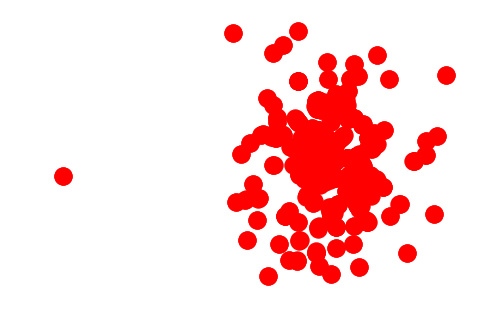

In [56]:
import matplotlib.pyplot as plt

G_Align=nx.Graph()
elist = unique_xmap
G_Align.add_weighted_edges_from(elist)
nx.draw(G_Align)
plt.show()

## compare node and edge connectivity
## compute largest connected component

In [57]:
print('Aligned graph have ',G_Align.number_of_nodes(),' nodes.')
print('Aligned graph have ',G_Align.number_of_edges(),' edges.')

Aligned graph have  1127  nodes.
Aligned graph have  2944  edges.


In [58]:
print('Target graph have ',G_target_na.number_of_nodes(),' nodes.')
print('Target graph have ',G_target_na.number_of_edges(), ' edges.')

Target graph have  1171  nodes.
Target graph have  4045  edges.


In [59]:
sum_weight=0
for i in range(len(unique_xmap)):
    sum_weight=sum_weight+ unique_xmap[i][2]
total_weight=0    
for i in range(len(nd1)):
    for j in range(len(nd2)):
        temp=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
        if(temp!=None):
            total_weight=total_weight+int(list(temp.values())[0])
print('Maximum Weight in Aligned graph: ',sum_weight) 
print('Total Weight in Target: ',total_weight)

Maximum Weight in Aligned graph:  347368
Total Weight in Target:  422185


In [60]:
# returns number of different connected components 
print('number of different connected components in Aligned graph: ',nx.number_connected_components(G_Align)) 
print('number of different connected components in Target graph: ',nx.number_connected_components(G_target_na))  

number of different connected components in Aligned graph:  106
number of different connected components in Target graph:  104


In [61]:
# returns list of nodes in different connected components 
cc_align=list(nx.connected_components(G_Align))
cc_target=list(nx.connected_components(G_target_na))
print(list(nx.connected_components(G_Align))) 
print(list(nx.connected_components(G_target_na)))

[{'ce14836', 'mm1305', 'ce4134', 'ce14445', 'mm6411', 'ce14700', 'ce33', 'ce2218', 'ce1064', 'ce8', 'mm126', 'ce27', 'ce3997', 'ce1168', 'ce8384', 'ce2179', 'ce11267', 'ce1767', 'mm1877', 'ce15008', 'mm504', 'ce7026', 'mm14063', 'ce6354', 'ce801', 'mm7428', 'mm2232', 'ce15247', 'mm3367', 'mm3657', 'ce14867', 'ce6402', 'ce5201', 'ce13565', 'ce1775', 'ce521', 'ce95', 'mm6119', 'mm303', 'ce3649', 'ce3851', 'ce1635', 'mm988', 'ce6915', 'ce142', 'ce1823', 'ce327', 'mm14346', 'ce322', 'ce7871', 'ce878', 'ce11240', 'ce2583', 'mm4782', 'mm890', 'mm4895', 'ce91', 'ce907', 'ce2414', 'ce1174', 'ce846', 'ce170', 'mm2709', 'ce5238', 'ce20', 'ce15750', 'mm5831', 'ce1686', 'mm2317', 'mm7826', 'ce2856', 'mm2388', 'ce311', 'ce196', 'mm2048', 'mm412', 'ce2240', 'mm7887', 'mm2952', 'ce7079', 'ce1466', 'ce3908', 'ce2675', 'ce362', 'ce1489', 'mm14749', 'ce541', 'mm1082', 'mm6126', 'ce1695', 'ce3310', 'ce16004', 'ce4681', 'mm112', 'mm1953', 'mm17603', 'ce8308', 'ce5264', 'ce730', 'ce1780', 'ce4264', 'ce1236

In [62]:
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(G_Align)) 
print(nx.node_connectivity(G_target_na))
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(G_Align))
print(nx.edge_connectivity(G_target_na))

0
0
0
0


## check similarity of connected components

In [63]:
count=0
for i in range(len(cc_align)):
    for j in range(len(cc_target)):
        if(cc_align[i]==cc_target[j]):
            count=count+1
print(count)

102


In [64]:
Gc = max(nx.connected_component_subgraphs(G_Align), key=len)
print('Largest common connected graph in Aligned graph: ',len(Gc))
Gct = max(nx.connected_component_subgraphs(G_target_na), key=len)
print('Largest common connected graph in Target graph: ',len(Gct))

Largest common connected graph in Aligned graph:  585
Largest common connected graph in Target graph:  646


### check for mistake align

In [65]:
for i in range(len(unique_xmap)):
    if (G_target_na.has_edge(unique_xmap[i][0], unique_xmap[i][1])==False):
        print(unique_xmap[i])
        print(i)
print('no exist error')    

no exist error


# Compute Global Criteria Percents

In [66]:
# total ec
total_ec=G_target_na.number_of_edges()/G1.number_of_edges()*100
ratio_ec=score_ec_temp/total_ec*100
print("total EC: ",total_ec)
print("Percent of EC: ",ratio_ec)
print("EC:",ratio_ec/100)

total EC:  229.82954545454547
Percent of EC:  72.78121137206426
EC: 0.7278121137206426


In [67]:
# total ics
total_ics=G_target_na.number_of_edges()/count_induced*100
ratio_ics=score_ics_temp/total_ics*100
print("total ICS: ",total_ics)
print("Percent of ICS: ",ratio_ics)
print("ICS:", ratio_ics/100)

total ICS:  81.96555217831813
Percent of ICS:  72.78121137206428
ICS: 0.7278121137206428


In [77]:
# total s3
total_s3=(G_target_na.number_of_edges()/(G1.number_of_edges()+count_induced-G_target_na.number_of_edges()))*100
ratio_s3=score_s3_temp/total_s3*100
print("total S3: ",total_s3)
print("Percent of S3: ",ratio_s3)
print("S3:",ratio_s3/100)

total S3:  152.64150943396226
Percent of S3:  51.41834447773137
S3: 0.5141834447773137


# compute FC

In [69]:
tree=[[unique_xmap[i][0],unique_xmap[i][1]] for i in range(len(unique_xmap))]
tree

[['mm5688', 'ce4233'],
 ['mm45', 'ce3649'],
 ['mm7258', 'ce10516'],
 ['mm3821', 'ce1979'],
 ['mm1472', 'ce13915'],
 ['mm1082', 'ce7446'],
 ['mm1082', 'ce404'],
 ['mm28', 'ce166'],
 ['mm6126', 'ce2061'],
 ['mm1953', 'ce622'],
 ['mm8252', 'ce3981'],
 ['mm11055', 'ce15048'],
 ['mm6564', 'ce2980'],
 ['mm16235', 'ce14293'],
 ['mm5610', 'ce6143'],
 ['mm2952', 'ce888'],
 ['mm1347', 'ce8786'],
 ['mm126', 'ce3570'],
 ['mm2545', 'ce1917'],
 ['mm1953', 'ce4948'],
 ['mm5678', 'ce16'],
 ['mm9112', 'ce3970'],
 ['mm3866', 'ce2713'],
 ['mm2398', 'ce4100'],
 ['mm8183', 'ce4323'],
 ['mm831', 'ce4083'],
 ['mm4686', 'ce994'],
 ['mm1953', 'ce3187'],
 ['mm6126', 'ce11741'],
 ['mm140', 'ce108'],
 ['mm1305', 'ce13915'],
 ['mm592', 'ce1825'],
 ['mm1105', 'ce1906'],
 ['mm4938', 'ce1425'],
 ['mm3244', 'ce2533'],
 ['mm19603', 'ce16627'],
 ['mm2013', 'ce42'],
 ['mm8533', 'ce4216'],
 ['mm18233', 'ce14867'],
 ['mm8139', 'ce8919'],
 ['mm4740', 'ce5264'],
 ['mm16191', 'ce15189'],
 ['mm1953', 'ce4424'],
 ['mm1612', 'ce

# load ontology and create DAG graph

In [70]:
import pandas as pd
f=open('go.dag.obo.txt').readlines()
df=pd.DataFrame(f)
df

,0
0,GO:0046431 GO:0019599\n
1,GO:0046430 GO:0019595\n
2,GO:0046432 GO:0019361\n
3,GO:0034198 GO:0060733\n
4,GO:0046343 GO:0019872\n
5,GO:0034193 GO:0034195\n
6,GO:0034192 GO:0034194\n
7,GO:0034190 GO:0034191\n
8,GO:0046437 GO:0030632 GO:0070179\n
9,GO:0046340 GO:0046342\n


In [71]:
# preprocessing
dag_list=[]
for i in range(len(df[0])):
    m1=str(df[0][i])
    m1=m1.replace('GO:','')
    m1=m1.replace('\n','')
    s=m1.split(' ')
    dag_list.append(s)
dag_list

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658', '0030853', '0045643', '0030854', '0045640'],
 ['0030853', '0045659', '0045644', '0045641'],
 ['0030851', '0030221', '0030223', '0030222'],
 ['0030856',
  '0003339',
  '0030860',
  '0045601',
  '0030857',
  '0072182',
  '0030858',
  '0045616'],
 ['0030857', '0045602', '0030861', '0045617', '0072183'],
 ['0030854', '0045645', '0045642', '0045660'],
 ['0030855',
  '0030859',
  '0030216',
  '0072192',
  '0060671',
  '0072160',
  '0060742',
  '0035026',
  '0072311',
  '0060487',
  '0045446',
  '0060644',
  '0002065'],
 ['0030858', '0045603', '0030862', '0045618'],
 ['0030859', '0045198'],
 ['0031106', '0032186'],
 ['0031105', '0032151', '0032152'],
 ['0031103', '0014814', '0048673', '0014012'],
 ['0031102', '00

In [72]:
dag_nd=[]
for i in range(len(dag_list)):
    for j in range(len(dag_list[i])):
        dag_nd.append(dag_list[i][j])
dag_nodes=set(dag_nd)
print(dag_nodes)
print(len(dag_nodes))

{'0007189', '0030840', '0048782', '0071199', '0071601', '0032796', '0006549', '0060068', '0051257', '0019626', '0015620', '0042422', '0043561', '0046960', '0002667', '0032787', '0072202', '0035020', '0016824', '0018148', '0010523', '0009083', '0015974', '0032932', '0050784', '0071147', '0000393', '0060655', '0006370', '0035399', '0016252', '0060472', '0019452', '0032584', '0071354', '0032211', '0006714', '0071510', '0000126', '0022619', '0052091', '0070795', '0010303', '0046337', '0004790', '0002041', '0001948', '0051284', '0000945', '0043825', '0019520', '0043469', '0048823', '0034981', '0000829', '0051220', '0031674', '0014744', '0031319', '0051130', '0030423', '0033221', '0008949', '0009209', '0045013', '0030676', '0015459', '0071346', '0007389', '0030756', '0000308', '0007358', '0045716', '0035164', '0005525', '0047071', '0005756', '0015292', '0002165', '0050183', '0050265', '0031801', '0019292', '0070548', '0045606', '0042482', '0002767', '0022023', '0071482', '0033610', '0050569'

In [73]:
# create dag edges
dag_edges=[]
for i in range(len(dag_list)):
    for j in range(1,len(dag_list[i])):
        ed=[dag_list[i][0],dag_list[i][j]]
        dag_edges.append(ed)
dag_edges

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632'],
 ['0046437', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658'],
 ['0030852', '0030853'],
 ['0030852', '0045643'],
 ['0030852', '0030854'],
 ['0030852', '0045640'],
 ['0030853', '0045659'],
 ['0030853', '0045644'],
 ['0030853', '0045641'],
 ['0030851', '0030221'],
 ['0030851', '0030223'],
 ['0030851', '0030222'],
 ['0030856', '0003339'],
 ['0030856', '0030860'],
 ['0030856', '0045601'],
 ['0030856', '0030857'],
 ['0030856', '0072182'],
 ['0030856', '0030858'],
 ['0030856', '0045616'],
 ['0030857', '0045602'],
 ['0030857', '0030861'],
 ['0030857', '0045617'],
 ['0030857', '0072183'],
 ['0030854', '0045645'],
 ['0030854', '0045642'],
 ['0030854', '0045660'],
 ['0030855', '0030859'],
 ['0030855', '0030216'],
 ['0030855', '0072192'],
 ['0030855', '0060671'],


In [74]:
import networkx as nx
go=nx.DiGraph()
go.add_nodes_from(dag_nodes)
go.add_edges_from(dag_edges)
go

In [75]:
# To unify the data, we need to delete the two letters of annotations and replace zero to achieve string with 7 lengths.
## According to species, these letters are different.
c=0
import numpy as np
na=tree
for i in range(len(tree)):
    for j in range(2):
        if ('mm' in tree[i][j] or 'ce' in tree[i][j]):
            s=tree[i][j][2:]
            x='0'*(7-len(s))
            y=x+s
            #print(y)
            na[i][j]=y
            c=c+1
print(len(tree),c)
print(len(na))

2944 5888
2944


In [76]:
fc=[]
for i in range(len(na)):
    if na[i][0] in dag_nodes:
        e=go.predecessors(na[i][0])
        if na[i][1] in dag_nodes: 
            f=go.predecessors(na[i][1])
            temp=[]
            for key in e:
                temp.append(key)
            for key in f:
                temp.append(key)
            # compute intersection/union 
            fc.append(sum([temp.count(temp[z])/len(temp) for z in range(len(temp))]))
        else:
            fc.append(0)
#print(fc)
# compute average of all fc 
func=np.average(fc)
print('functional coherence:',func)

functional coherence: 0.5842263583380334
